#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 10
**CH10B Finding a good deal among hotels with multiple regression**

using the hotels-vienna dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import pyfixest as pf
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
current_path = os.getcwd()
base_dir = current_path.split("da_case_studies")[0]
data_in = os.path.join(str(base_dir) , "da_data_repo/hotels-vienna/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch10-hotels-multiple-reg/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")
sys.path.append(func)

In [3]:
import da_helper_functions as da
sns.set_theme(rc=da.da_theme, palette=da.color)

In [4]:
hotels = pd.read_csv(os.path.join(data_in, "hotels-vienna.csv"))
# hotels = pd.read_csv("https://osf.io/y6jvb/download")

In [5]:
hotels = hotels.loc[
    lambda x: (x["accommodation_type"] == "Hotel")
    & (x["city_actual"] == "Vienna")
    & (x["stars"] >= 3)
    & (x["stars"] <= 4)
    & (x["price"] <= 600)
    & (x["stars"].notnull())
]

In [6]:
len(hotels)

207

In [7]:
hotels["lnprice"] = np.log(hotels["price"])
hotels["distance2"] = hotels["distance"]
hotels.loc[hotels["distance2"] < 0.05, "distance2"] = 0.05
hotels["lndistance"] = np.log(hotels["distance2"])
hotels["star35"] = hotels["stars"] == 3.5
hotels["star4"] = hotels["stars"] == 4

In [8]:
hotels[["distance", "price", "lnprice"]].describe()

,distance,price,lnprice
count,207.000000,207.000000,207.000000
mean,1.529952,109.975845,4.640219
std,1.161507,42.221381,0.336751
min,0.000000,50.000000,3.912023
25%,0.800000,82.000000,4.406719
50%,1.300000,100.000000,4.605170
75%,1.900000,129.500000,4.863673
max,6.600000,383.000000,5.948035


In [9]:
reg0 = pf.feols("lnprice ~ rating", data=hotels)
reg1 = pf.feols("lnprice ~ distance", data=hotels)
reg2 = pf.feols("lnprice ~ distance + rating", data=hotels)

In [10]:
pf.etable([reg0,reg1,reg2])

GT(_tbl_data=  level_0             level_1                      0                       1  \
0    coef              rating  0.442*** <br> (0.053)                           
1    coef            distance                         -0.131*** <br> (0.018)   
2    coef           Intercept  2.846*** <br> (0.217)   4.841*** <br> (0.035)   
3   stats        Observations                    207                     207   
4   stats           S.E. type                    iid                     iid   
5   stats       R<sup>2</sup>                  0.252                   0.205   
6   stats  Adj. R<sup>2</sup>                  0.248                   0.201   

                        2  
0   0.365*** <br> (0.051)  
1  -0.101*** <br> (0.017)  
2   3.316*** <br> (0.215)  
3                     207  
4                     iid  
5                   0.365  
6                   0.359  , _body=<great_tables._gt_data.Body object at 0x167e64980>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x167e52fc0>, _spanners=Spanners([SpannerInfo(spanner_id='lnprice', spanner_level=1, spanner_label='lnprice', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x167e538f0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_wi

In [11]:
reg3 = pf.feols(
    "lnprice ~ da.lspline(distance,[1,4]) + da.lspline(rating, [3.5]) + star35 + star4",
    data=hotels,
    context=0,
)

In [12]:
pf.etable(reg3)

GT(_tbl_data=   level_0                          level_1                       0
0     coef  da.lspline(distance, [1, 4])[0]  -0.460*** <br> (0.067)
1     coef  da.lspline(distance, [1, 4])[1]    -0.050* <br> (0.021)
2     coef  da.lspline(distance, [1, 4])[2]      0.143 <br> (0.081)
3     coef     da.lspline(rating, [3.5])[0]     -0.113 <br> (0.132)
4     coef     da.lspline(rating, [3.5])[1]   0.360*** <br> (0.059)
5     coef                           star35      0.017 <br> (0.071)
6     coef                            star4   0.150*** <br> (0.037)
7     coef                        Intercept   5.155*** <br> (0.454)
8    stats                     Observations                     207
9    stats                        S.E. type                     iid
10   stats                    R<sup>2</sup>                   0.550
11   stats               Adj. R<sup>2</sup>                   0.534, _body=<great_tables._gt_data.Body object at 0x167e52b70>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x167e43890>, _spanners=Spanners([SpannerInfo(spanner_id='lnprice', spanner_level=1, spanner_label='lnprice', spanner_units=None, spanner_pattern=None, vars=['0'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x167e43ad0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, c

In [13]:
hotels["lnprice_hat"] = reg3.predict()
hotels["lnprice_resid"] = hotels["lnprice"] - hotels["lnprice_hat"]

hotels["bestdeals"] = hotels.index.isin(
    hotels["lnprice_resid"].sort_values(ascending=False).tail().index.values
)
hotels["lnprice_hat"]
hotels.loc[hotels["bestdeals"]][["price","lnprice_resid","distance","stars","rating"]]

,price,lnprice_resid,distance,stars,rating
10,60,-0.564581,1.1,4.0,4.1
60,115,-0.405084,0.1,4.0,4.3
153,54,-0.338400,1.1,3.0,3.2
239,75,-0.334896,0.7,3.0,4.1
374,50,-0.384566,3.9,3.0,3.9


In [14]:
reg4 = pf.feols("lnprice ~ da.lspline(distance,[1,4])", data=hotels,context=0)

In [15]:
pf.etable([reg1, reg2, reg3, reg4])

GT(_tbl_data=   level_0                          level_1                       0  \
0     coef                         distance  -0.131*** <br> (0.018)   
1     coef                           rating                           
2     coef  da.lspline(distance, [1, 4])[0]                           
3     coef  da.lspline(distance, [1, 4])[1]                           
4     coef  da.lspline(distance, [1, 4])[2]                           
5     coef     da.lspline(rating, [3.5])[0]                           
6     coef     da.lspline(rating, [3.5])[1]                           
7     coef                           star35                           
8     coef                            star4                           
9     coef                        Intercept   4.841*** <br> (0.035)   
10   stats                     Observations                     207   
11   stats                        S.E. type                     iid   
12   stats                    R<sup>2</sup>                   0.205   
13   stats               Adj. R<sup>2</sup>                   0.201   

                         1                       2                       3  
0   -0.101*** <br> (0.017)                                                  
1    0.365*** <br> (0.051)                                                  
2                           -0.460*** <br> (0.067)  -0.599*** <br> (0.076)  
3                             -0.050* <br> (0.021)   -0.075** <br> (0.025)  
4                               0.143 <br> (0.081)      0.173 <br> (0.093)  
5                              -0.113 <br> (0.132)                          
6                            0.360*** <br> (0.059)                          
7                               0.017 <br> (0.071)                          
8                            0.150*** <br> (0.037)                          
9    3.316*** <br> (0.215)   5.155*** <br> (0.454)   5.181*** <br> (0.060)  
10                     207                     207                     207  
11                     iid                     iid                     iid  
12                   0.365                   0.550                   0.371  
13                   0.359                   0.534                   0.362  , _body=<great_tables._gt_data.Body object at 0x167deb860>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x167dea690>, _spanners=Spanners([SpannerInfo(spanner_id='lnprice', spanner_level=1, spanner_label='lnprice', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x167debda0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type=

### Figure 10.3 ˆy−y plot for log hotel price

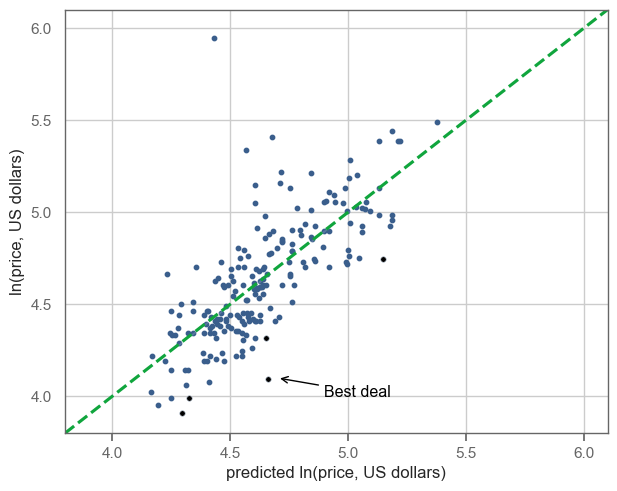

In [16]:
plt.xlim(3.8, 6.1)
sns.regplot(
    data=hotels,
    x="lnprice_hat",
    y="lnprice",
    ci=False,
    truncate=False,
    line_kws=dict(color=da.color[1], linestyle="dashed"),
    scatter_kws=dict(alpha=1, s=10),
)

sns.scatterplot(
    hotels.loc[hotels["bestdeals"] == True],
    x="lnprice_hat",
    y="lnprice",
    color="black",
    s=15,
    zorder=3,
)

plt.xlabel("predicted ln(price, US dollars)", fontsize=12)
plt.ylabel("ln(price, US dollars)", fontsize=12)
plt.xticks(np.arange(4, 6.1, 0.5))
plt.ylim(3.8, 6.1)
plt.yticks(np.arange(4, 6.1, 0.5))
plt.annotate(
    "Best deal",
    xy=(4.7, 4.1),
    xytext=(4.9, 4),
    arrowprops=dict(color="black", arrowstyle="->"),
    fontsize=11.5,
)
plt.show()

### Residual plot - not in the book

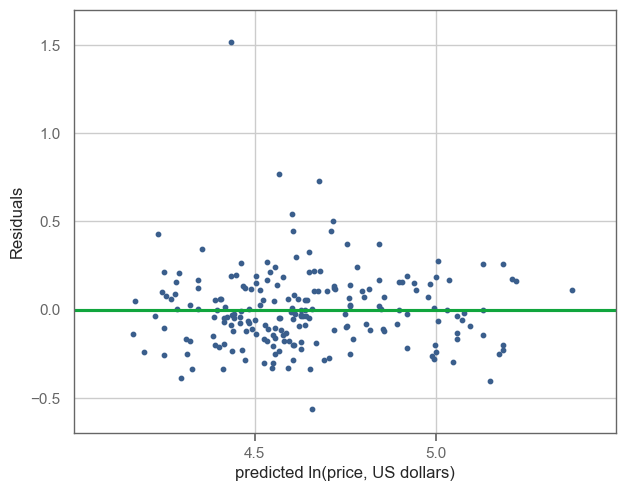

In [ ]:
plt.xlim(4, 5.5)
sns.regplot(
    data=hotels,
    x="lnprice_hat",
    y="lnprice_resid",
    ci=False,
    truncate=False,
    line_kws=dict(color=da.color[1]),
    scatter_kws=dict(alpha=1, s=10),
)


plt.xlabel("predicted ln(price, US dollars)", fontsize=12)
plt.ylabel("Residuals", fontsize=12)

plt.xticks(np.arange(4.5, 5.1, 0.5))
plt.ylim(-0.7, 1.7)
plt.yticks(np.arange(-0.5, 1.51, 0.5))
plt.show()